<a href="https://colab.research.google.com/github/ArmandDS/news_category/blob/master/News_Analysis_AO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Data 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls -ls /content/gdrive/'My Drive'/WJaguarTest

total 25721
25721 -rw------- 1 root root 26337702 May 24 00:15 news-category-dataset.zip


In [4]:
!unzip   /content/gdrive/'My Drive'/WJaguarTest/news-category-dataset.zip

Archive:  /content/gdrive/My Drive/WJaguarTest/news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


#### Load libraries we will need 

In [0]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.linear_model import SGDClassifier
import logging
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [6]:
df_news = pd.read_json("News_Category_Dataset_v2.json", lines = True)
df_news.columns

Index(['authors', 'category', 'date', 'headline', 'link', 'short_description'], dtype='object')

In [7]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
authors              200853 non-null object
category             200853 non-null object
date                 200853 non-null datetime64[ns]
headline             200853 non-null object
link                 200853 non-null object
short_description    200853 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [8]:
df_news.head()

,authors,category,date,headline,link,short_description
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ..."


Category Distribution

In [9]:
len(df_news['category'].unique())

41

There are 41 categories in the dataset

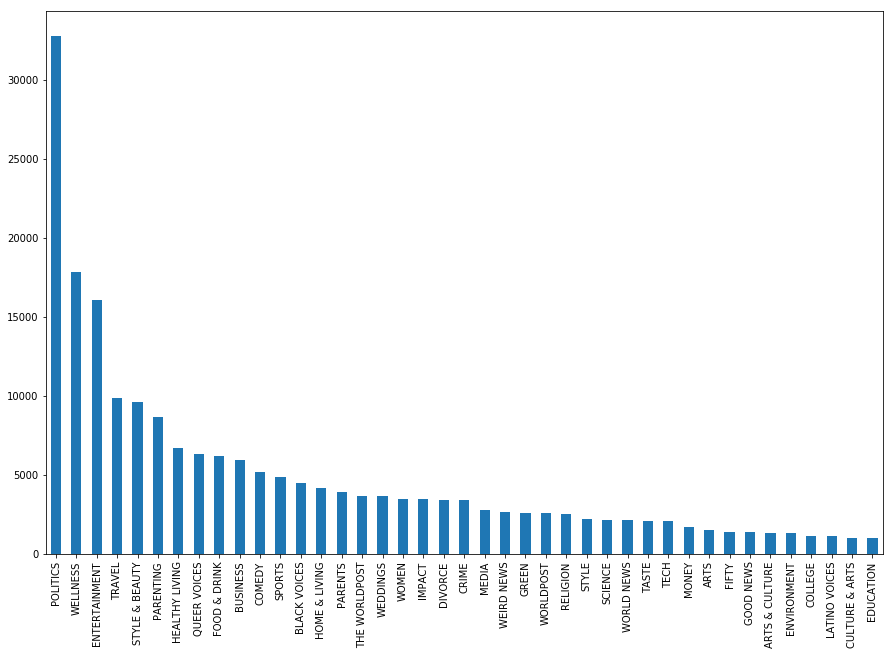

In [10]:
df_news['category'].value_counts().plot( kind='bar', figsize=(15,10))

#### Data pre-processing

load the nltk utilities

In [11]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

#### Function to clean, tokenize, remove stop word, and not alphanumeric from data

In [0]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

my_sw = ['make', 'amp',  'news','new' ,'time', 'u','s', 'photos',  'get', 'say']
def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text)    
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

In [13]:
df_news.short_description[0]

'She left her husband. He killed their children. Just another day in America.'

#### Processing the Data and TF-IDF

We need to merge the categories _WORDLPOST_ with _THE WORDPOST_, because there *are* basically the same, next we combine the columns _headline with _short_description_ these are our predictor text

In [0]:
df_news.category = df_news.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [0]:
df_news['text'] = df_news['headline'] + " " + df_news['short_description']

example output

In [16]:
df_news.text[10]

'Justin Timberlake Visits Texas School Shooting Victims The pop star also wore a "Santa Fe Strong" shirt at his show in Houston.'

In [17]:
clean_txt(df_news.text[10])

'justin timberlake visit texas school shoot victims pop star also wear santa strong shirt show houston'

In [18]:
clean_txt(df_news.text[5])

'morgan freeman devastate sexual harassment claim could undermine legacy right equate horrific incidents sexual assault misplace compliment humor statement'

#### Next we are going to create some news variables columns to try to improve the quaity of our classifier, we will create:
 * Polarity: to check the sentiment of the text
 * Subjectivity: to check if text is objective or subjective
 * The number of word in the text

In [19]:
blob = TextBlob((df_news.text[1]))
str(blob.correct())

"Will Smith Coins Diplo And Sick Am For The 2018 World Up's Official Long Of course it has a song."

In [0]:
def polarity_txt(text):
  return TextBlob(text).sentiment[0] 

In [0]:
def subj_txt(text):
  return  TextBlob(text).sentiment[1]

In [0]:
def len_text(text):
  if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
  else:
         return 0

In [23]:
df_news['polarity'] = df_news['text'].apply(polarity_txt)
df_news.head(2)

,authors,category,date,headline,link,short_description,text,polarity
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,-0.05
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,0.00


In [24]:
df_news['subjectivity'] = df_news['text'].apply(subj_txt)
df_news.head(2)

,authors,category,date,headline,link,short_description,text,polarity,subjectivity
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,-0.05,0.266667
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,0.00,0.000000


In [25]:
df_news['len'] = df_news['text'].apply(len_text)
df_news.head(2)

,authors,category,date,headline,link,short_description,text,polarity,subjectivity,len
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,-0.05,0.266667,0.444444
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,0.00,0.000000,0.500000


#### Make the Custom class for feature union Transformer of sklearn

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pos':  row['polarity'], 'sub': row['subjectivity'],  'len': row['len']} for _, row in data.iterrows()]


### Make our Custom Pipeline

In [0]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='text')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['polarity', 'subjectivity', 'len'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': 0.9,
            'stats': 1.5,
        },
    ))
])

##### Build the pipeline

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
seed = 40
X = df_news[['text', 'polarity', 'subjectivity','len']]
y =df_news['category']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [30]:
pipeline.fit(x_train)

Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ItemSelector(key='text')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
                      

### Transform and train the ML models

In [31]:
%%time
train_vec = pipeline.transform(x_train)
test_vec = pipeline.transform(x_test)
print("Checking that the number of features in train and test correspond: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the number of features in train and test correspond: (160682, 189409) - (40171, 189409)
CPU times: user 1min 53s, sys: 51.9 ms, total: 1min 53s
Wall time: 1min 53s


In [0]:
clf_sv = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40, max_iter=10000) #Support Vector machines
clf_sgd = SGDClassifier(max_iter=200,) # Stochastic Gradient Classifier

In [33]:
%%time
from sklearn.model_selection import cross_val_score

clfs = [clf_sv, clf_sgd]
cv = 3
for clf in clfs:
    scores = cross_val_score(clf,train_vec, y_train, cv=cv, scoring="accuracy" )
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), np.std(scores)))

[0.60213167 0.60403637 0.60228589]
Mean score: 0.603 (+/-0.001)
[0.57823904 0.57974721 0.57255444]
Mean score: 0.577 (+/-0.003)
CPU times: user 2min 20s, sys: 10.6 s, total: 2min 31s
Wall time: 2min 17s


In [34]:
%%time
from sklearn.metrics import classification_report
clf_sv.fit(train_vec, y_train )
y_pred = clf_sv.predict(test_vec)
list_result =[]
list_result.append(("SVC",accuracy_score(y_test, y_pred)))
clf_sgd.fit(train_vec, y_train )
y_pred = clf_sgd.predict(test_vec)
list_result.append(("SGD",accuracy_score(y_test, y_pred)))


CPU times: user 1min 16s, sys: 3.41 s, total: 1min 20s
Wall time: 1min 15s


### Deep Learning and Spacy Models

In [35]:
import spacy
!python -m spacy download en_core_web_lg


     |████████████████████████████████| 852.3MB 37.8MB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-y2841n1g/wheels/0d/bc/67/e6a9108ab86cd076703af19ad4e0f02f57381ac6583df16249
Successfully built en-core-web-lg

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [0]:
nlp = spacy.load('en_core_web_lg')

In [37]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import train_test_split
import time
X = df_news['text']
y =df_news['category']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
Y = np_utils.to_categorical(y)
##Create the tf-idf vector
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = None, preprocessor=clean_txt)





In [39]:
seed = 40
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify =y)
vectorizer.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.2, max_features=None,
                min_df=3, ngram_range=(1, 1), norm='l2',
                preprocessor=<function clean_txt at 0x7efddb91e378>,
                smooth_idf=1, stop_words=None, strip_accents='unicode',
                sublinear_tf=1, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=1, vocabulary=None)

In [40]:

word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()
 
def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes

X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_train]
print(X_train_sequences[0])
 

[18668, 11954, 25588, 19448, 25191, 20685, 29263, 12600, 28350, 25877, 24540, 27487, 24293]


In [41]:
# Compute the max lenght of a text

MAX_SEQ_LENGHT=60

N_FEATURES = len(vectorizer.get_feature_names())
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])
 

[29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942
 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942
 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942
 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 29942 18668
 11954 25588 19448 25191 20685 29263 12600 28350 25877 24540 27487 24293]


In [0]:
X_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_test]
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
 

#### Making the spacy embeding

In [43]:
EMBEDDINGS_LEN = 300

embeddings_index = np.zeros((len(vectorizer.get_feature_names()) + 1, EMBEDDINGS_LEN))
for word, idx in word2idx.items():
    try:
        embedding = nlp.vocab[word].vector
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)   
      

EMBEDDINGS_LEN= 300


#### Simple LSTM Model

In [44]:
 
model = Sequential()
model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(LSTM(300, dropout=0.2))
model.add(Dense(len(set(y)), activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 300)           8982900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 40)                12040     
Total params: 9,716,140
Trainable params: 733,240
Non-trainable params: 8,982,900
_________________________________________________________________
None


In [45]:
model.fit(X_train_sequences, y_train, 
          epochs=5, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate(X_test_sequences, y_test, verbose=1)
print("Accuracy:", scores[1])  #
list_result.append(("LSTM Simple", scores[1]))

Instructions for updating:
Use tf.cast instead.
Train on 144613 samples, validate on 16069 samples
Epoch 1/5
144613/144613 [==============================] - 103s 712us/step - loss: 1.5857 - acc: 0.5599 - val_loss: 1.3232 - val_acc: 0.6206
Epoch 2/5
144613/144613 [==============================] - 101s 699us/step - loss: 1.2761 - acc: 0.6254 - val_loss: 1.2443 - val_acc: 0.6374
Epoch 3/5
144613/144613 [==============================] - 101s 696us/step - loss: 1.1632 - acc: 0.6523 - val_loss: 1.2112 - val_acc: 0.6450
Epoch 4/5
144613/144613 [==============================] - 102s 703us/step - loss: 1.0752 - acc: 0.6735 - val_loss: 1.2070 - val_acc: 0.6457
Epoch 5/5
40171/40171 [==============================] - 44s 1ms/step
Accuracy: 0.6476064822852503


In [46]:
len(x_train.keys())

160682

### Model LSTM and concatenate new columns

In [48]:
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten,BatchNormalization, GRU

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((LSTM(300, dropout=0.2, recurrent_dropout=0.2)))(x)
x4 = concatenate([x2, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 60, 300)      8982900     text[0][0]                       
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 300)          721200      embedding_3[0][0]                
__________________________________________________________________________________________________
meta (InputLayer)               (None, 3)            0                                            
__________________________________________________________________________________________________
concatenat

In [0]:
df_cat_train = df_news.iloc[x_train.index][['polarity', 'subjectivity', 'len']]
df_cat_test = df_news.iloc[x_test.index][['polarity', 'subjectivity', 'len']]

In [50]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=12, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  
list_result.append(("LSTM with Multi-Input", scores[1]))

Train on 144613 samples, validate on 16069 samples
Epoch 1/12
144613/144613 [==============================] - 111s 766us/step - loss: 1.7566 - acc: 0.5272 - val_loss: 1.3609 - val_acc: 0.6161
Epoch 2/12
144613/144613 [==============================] - 109s 754us/step - loss: 1.3914 - acc: 0.6040 - val_loss: 1.2578 - val_acc: 0.6356
Epoch 3/12
144613/144613 [==============================] - 108s 750us/step - loss: 1.2812 - acc: 0.6285 - val_loss: 1.2375 - val_acc: 0.6398
Epoch 4/12
144613/144613 [==============================] - 108s 749us/step - loss: 1.2064 - acc: 0.6458 - val_loss: 1.2024 - val_acc: 0.6524
Epoch 5/12
144613/144613 [==============================] - 107s 741us/step - loss: 1.1409 - acc: 0.6606 - val_loss: 1.2080 - val_acc: 0.6483
Epoch 6/12
144613/144613 [==============================] - 107s 740us/step - loss: 1.0848 - acc: 0.6732 - val_loss: 1.2012 - val_acc: 0.6540
Epoch 7/12
144613/144613 [==============================] - 107s 740us/step - loss: 1.0345 - acc:

### Model with 2 GRU (Bi-GRU)

In [51]:

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((GRU(128, dropout=0.2, recurrent_dropout=0.2,  return_sequences=True)))(x)
x3 = ((GRU(128, dropout=0.2, recurrent_dropout=0.2)))(x2)
x4 = concatenate([x3, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 60, 300)      8982900     text[0][0]                       
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 60, 128)      164736      embedding_4[0][0]                
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 128)          98688       gru_1[0][0]                      
__________________________________________________________________________________________________
meta (Inpu

In [53]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=20, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  # 
list_result.append(("Bi-GRU", scores[1]))

Train on 144613 samples, validate on 16069 samples
Epoch 1/20
144613/144613 [==============================] - 181s 1ms/step - loss: 1.8974 - acc: 0.4958 - val_loss: 1.4269 - val_acc: 0.5979
Epoch 2/20
144613/144613 [==============================] - 180s 1ms/step - loss: 1.4980 - acc: 0.5815 - val_loss: 1.3287 - val_acc: 0.6213
Epoch 3/20
144613/144613 [==============================] - 178s 1ms/step - loss: 1.4091 - acc: 0.6007 - val_loss: 1.2782 - val_acc: 0.6293
Epoch 4/20
144613/144613 [==============================] - 179s 1ms/step - loss: 1.3544 - acc: 0.6135 - val_loss: 1.2581 - val_acc: 0.6341
Epoch 5/20
144613/144613 [==============================] - 178s 1ms/step - loss: 1.3124 - acc: 0.6228 - val_loss: 1.2408 - val_acc: 0.6395
Epoch 6/20
144613/144613 [==============================] - 177s 1ms/step - loss: 1.2806 - acc: 0.6289 - val_loss: 1.2275 - val_acc: 0.6460
Epoch 7/20
144613/144613 [==============================] - 179s 1ms/step - loss: 1.2558 - acc: 0.6358 - val_

## LSTM with Attention

In [56]:
             
             
             
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x = Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False)(text_data)
x1 = (LSTM(300, dropout=0.25, recurrent_dropout=0.25, return_sequences=True))(x)
x2 = Dropout(0.25)(x1)
x3 = Attention(MAX_SEQ_LENGHT)(x2)
x4 = Dense(256, activation='relu')(x3)
x5 = Dropout(0.25)(x4)
x6 = BatchNormalization()(x5)
x7 = concatenate([x6, meta_data])
x8 = Dense(150, activation='relu')(x7)
x9 = Dropout(0.25)(x8)
x10 = BatchNormalization()(x9)
outp = Dense(len(set(y)), activation='softmax')(x10)

AttentionLSTM = Model(inputs=[text_data, meta_data ], outputs=outp)
AttentionLSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

AttentionLSTM.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 60, 300)      8982900     text[0][0]                       
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 60, 300)      721200      embedding_6[0][0]                
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 60, 300)      0           lstm_5[0][0]                     
__________________________________________________________________________________________________
attention_

In [57]:
AttentionLSTM.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=13, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = AttentionLSTM.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  # 
list_result.append(("LSTM with Attention", scores[1]))

Train on 144613 samples, validate on 16069 samples
Epoch 1/13
144613/144613 [==============================] - 119s 820us/step - loss: 1.8267 - acc: 0.5141 - val_loss: 1.3845 - val_acc: 0.6058
Epoch 2/13
144613/144613 [==============================] - 115s 793us/step - loss: 1.4734 - acc: 0.5892 - val_loss: 1.3059 - val_acc: 0.6256
Epoch 3/13
144613/144613 [==============================] - 113s 783us/step - loss: 1.3731 - acc: 0.6112 - val_loss: 1.2491 - val_acc: 0.6384
Epoch 4/13
144613/144613 [==============================] - 115s 795us/step - loss: 1.3028 - acc: 0.6266 - val_loss: 1.2149 - val_acc: 0.6466
Epoch 5/13
144613/144613 [==============================] - 113s 784us/step - loss: 1.2492 - acc: 0.6389 - val_loss: 1.2049 - val_acc: 0.6462
Epoch 6/13
144613/144613 [==============================] - 115s 797us/step - loss: 1.2059 - acc: 0.6492 - val_loss: 1.1796 - val_acc: 0.6534
Epoch 7/13
144613/144613 [==============================] - 116s 800us/step - loss: 1.1639 - acc:

##  Models Comparison

In [63]:
pd.DataFrame(list_result, columns=['model', 'accuracy'])

,model,accuracy
0,SVC,0.613477
1,SGD,0.582460
2,LSTM Simple,0.647606
3,LSTM with Multi-Input,0.648528
4,Bi-GRU,0.650494
5,LSTM with Attention,0.660427


The Confusion Matrix for the best models

## Do news articles from different categories have different writing styles?

#### Let's see the top word by category

In [0]:
%%time
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 1), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)
vectorizer.fit(df_news.category)

CPU times: user 18.7 s, sys: 0 ns, total: 18.7 s
Wall time: 18.7 s


In [0]:

def create_tf_matrix(category):
    return vectorizer.transform(df_news[df_news.category == category].text)

def create_term_freq(matrix, cat):
  category_words = matrix.sum(axis=0)
  category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
  return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in df_news.category.unique():
  print("Top 10 terms for: ", cat)
  df_right = create_term_freq(create_tf_matrix(cat), cat).head(10)
  print(df_right)
  print("###############")
  if cat != 'CRIME':
    df_top5_words = df_top5_words.merge(df_right, how='outer')
  else:
    df_top5_words = df_right.copy()
  print(df_top5_words.shape )

  

Top 10 terms for:  CRIME
     Terms       CRIME
0     home  122.780746
1    crime   61.279350
2    black   54.603386
3    drink   50.149849
4     live   47.139003
5   parent   42.693406
6    women   42.479414
7  college   26.158697
8     good   24.768079
9    money   22.500460
###############
(10, 2)
Top 10 terms for:  ENTERTAINMENT
    Terms  ENTERTAINMENT
0    live     356.901616
1    good     336.142522
2   world     331.985059
3   women     239.054035
4   black     204.679678
5    home     153.132509
6  comedy     145.462310
7   media     114.164769
8   voice     109.243520
9  parent      79.957844
###############
(14, 3)
Top 10 terms for:  WORLD NEWS
      Terms  WORLD NEWS
0     world  107.477013
1     women   57.656851
2     media   30.497552
3      live   27.490777
4      home   26.794834
5      good   15.763163
6     black   13.506478
7    travel   12.679764
8      food   12.658104
9  politics   10.013183
###############
(17, 4)
Top 10 terms for:  IMPACT
       Terms      IMPA

In [0]:
df_top5_words.fillna(0, inplace=True )
df_top5_words.set_index('Terms', inplace=True)
df_top5_words.shape

(37, 40)

In [0]:
!pip install textacy

In [0]:
import numpy as np
from textacy.viz.termite import draw_termite_plot


In [0]:
df = df_top5_words.copy()
df_norm = (df) / (df.max() - df.min())

#### According the TFIDF we get the following top-10  term by category

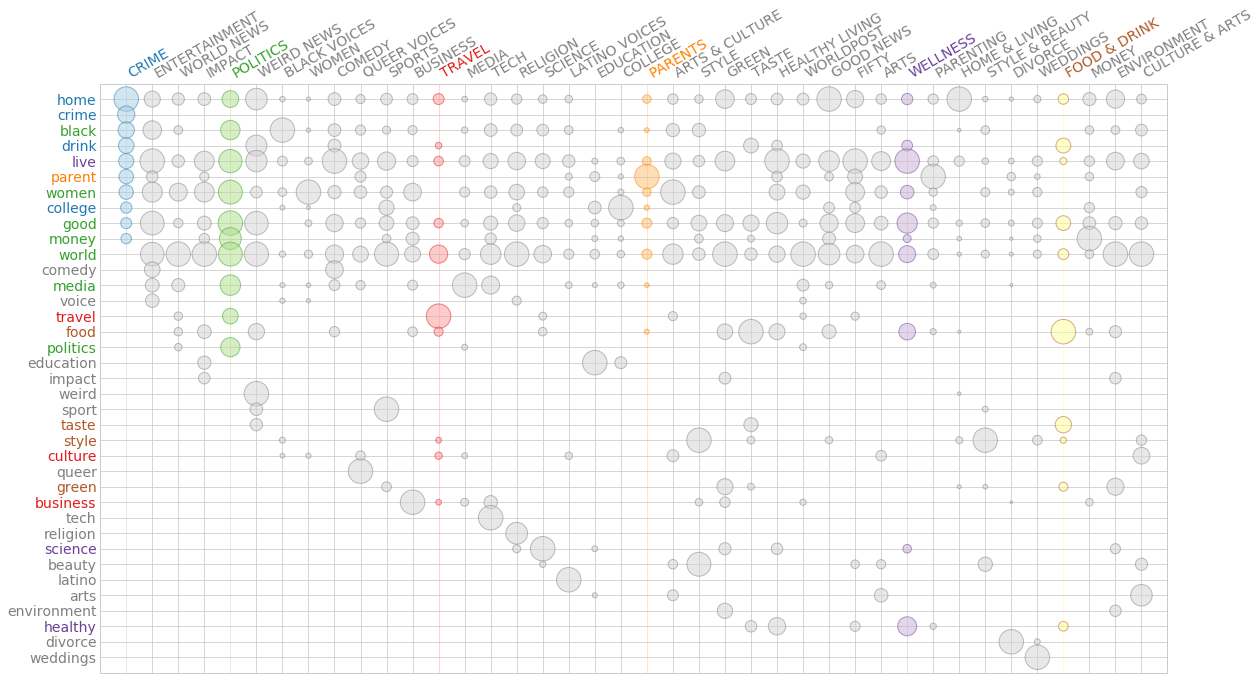

In [0]:
draw_termite_plot(np.array(df_norm.values),df_top5_words.columns,df_top5_words.index, highlight_cols=[0, 4, 12,20,30,36] )

we see words for example: 
* for category _CRIME_ we have words like: _home,  crime,    black,  drink,  live, parent,   money_.
* for category _TRAVEL_ we have:  _world,  food, culture,     drink_ , i.e Wor we can use for travel description



Let´s get some metada data by categories

In [0]:

import textacy

In [0]:
def get_basic_stat(text):
  doc = textacy.make_spacy_doc(text, lang=nlp)
  ts = textacy.TextStats(doc)
  return  ts.basic_counts

Group by Categories in order to analize the Data

In [0]:
%%time
df_news['Stats'] = df_news['text'].apply(get_basic_stat)

CPU times: user 1h 21min 14s, sys: 33min 29s, total: 1h 54min 44s
Wall time: 58min 12s


In [0]:
df_news.head()

,authors,category,date,headline,link,short_description,text,polarity,subjectivity,len,Stats
0,Melissa Jeltsen,CRIME,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,-0.050000,0.266667,0.444444,"{'n_sents': 6, 'n_words': 27, 'n_chars': 111, ..."
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,0.000000,0.000000,0.500000,"{'n_sents': 3, 'n_words': 21, 'n_chars': 80, '..."
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 5...,0.250000,0.333333,0.560000,"{'n_sents': 4, 'n_words': 25, 'n_chars': 110, ..."
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,-0.051768,0.498737,0.720000,"{'n_sents': 2, 'n_words': 26, 'n_chars': 128, ..."
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...,0.200000,0.200000,0.576923,"{'n_sents': 2, 'n_words': 26, 'n_chars': 128, ..."


In [0]:
df_stats = pd.DataFrame(df_news['Stats'].values.tolist(), index=df_news.index)
df_stats.head()

,n_chars,n_long_words,n_monosyllable_words,n_polysyllable_words,n_sents,n_syllables,n_unique_words,n_words
0,111,5,21,2,6,35,26,27
1,80,1,19,1,3,24,20,21
2,110,5,17,1,4,35,23,25
3,128,6,19,1,2,34,26,26
4,128,6,14,4,2,43,24,26


### The sentiment by Category

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

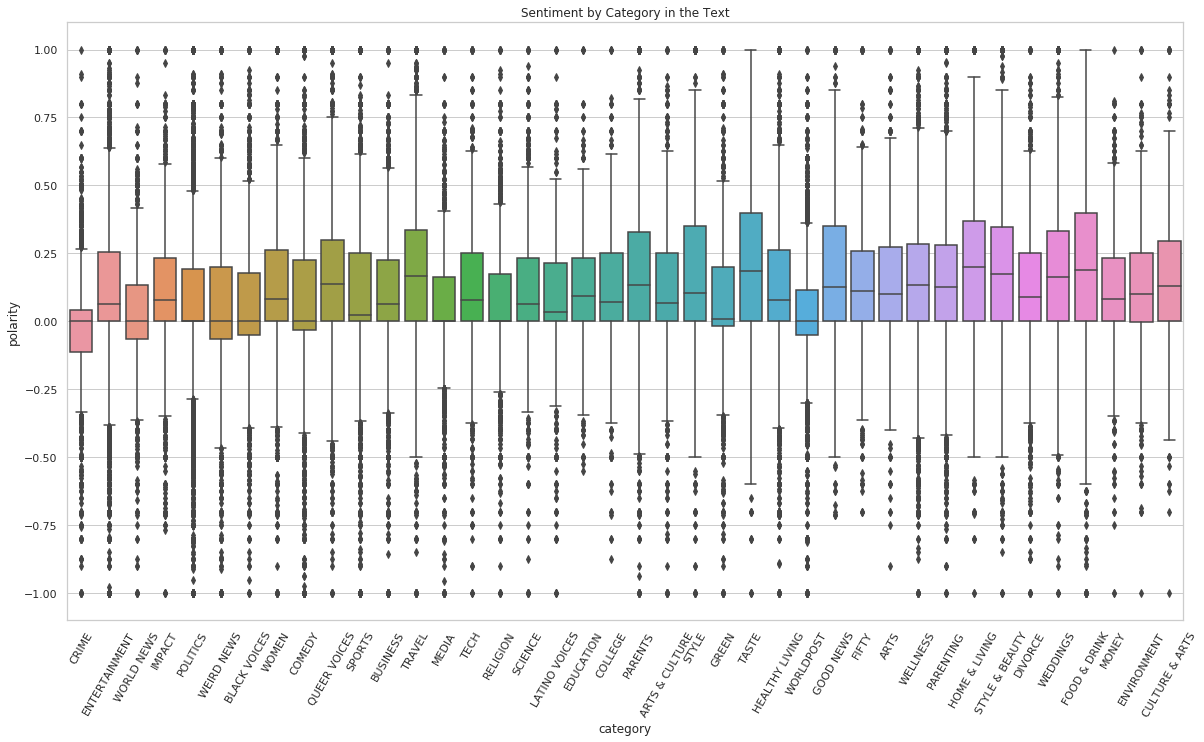

In [0]:
plt.figure(figsize=(20,11))
ax = sns.boxplot(x="category", y="polarity", data=df_news)
# ax = sns.swarmplot(x="category", y="polarity", data=df_news, color=".25")
ax.set_title('Sentiment by Category in the Text')
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

The highest sentiment polarity score was achieved by all the categoris **TASTE  and FOOOD & DRING**, and the lowest sentiment polarity score was collected by categories **CRIME and WORLD NEWS**.  This is explains because categories as  _CRIME_ as some more words associated with negative feelings, whereas categories like **FOODS & DRINK** has more word associated to pleasure.

### The Objectivity by Category

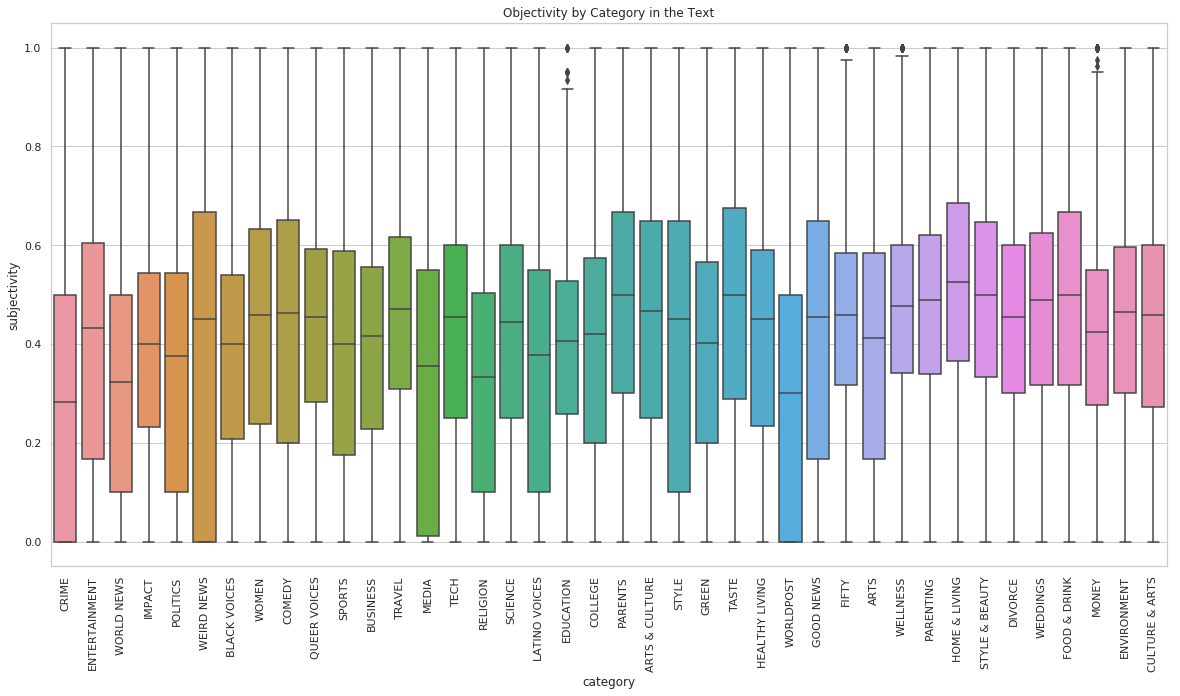

In [0]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="category", y="subjectivity", data=df_news)
# ax = sns.swarmplot(x="category", y="subjectivity", data=df_news, color=".25")
ax.set_title('Objectivity by Category in the Text')
l= ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

The highest subjectivity score by mean was achieved by categories **PARECTS, HOME & LIVING and TASTE** refers that mostly it is a public opinion and not a factual information., and the lowest subjectivity score was collected by **CRIME and WORLDPOST** for example.  however these text are all should considered to be objective because are all news.

### Articles Published by year

In [0]:
df_news['year']= df_news['date'].dt.year

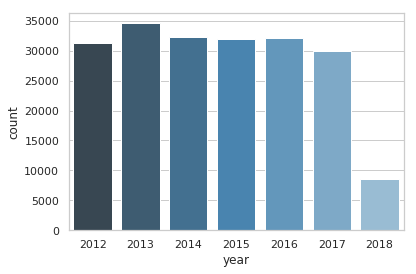

In [0]:
ax.set_title('Number of news by Year')
ax = sns.countplot(x="year", data=df_news, palette="Blues_d")

The news published by year is kind of uniform

### News by category an year

In [0]:
df_news['qty']= 1
df_cat_year = df_news.groupby(['category', 'year']).agg({'polarity': 'mean', 
                                     'subjectivity': 'mean', 
                                    'len': 'mean',
                                     'qty':'count'})
df_cat_year.head(6)

polarity  subjectivity       len  qty
category       year                                       
ARTS           2014  0.141188      0.402685  0.573101  801
               2015  0.148922      0.403176  0.559106  618
               2016  0.141777      0.340253  0.607920   87
               2017 -0.233333      0.433333  0.828070    3
ARTS & CULTURE 2015  0.090684      0.473747  0.577164  207
               2016  0.117191      0.466411  0.592528  596

In [0]:
df_cat_year.reset_index(inplace=True)

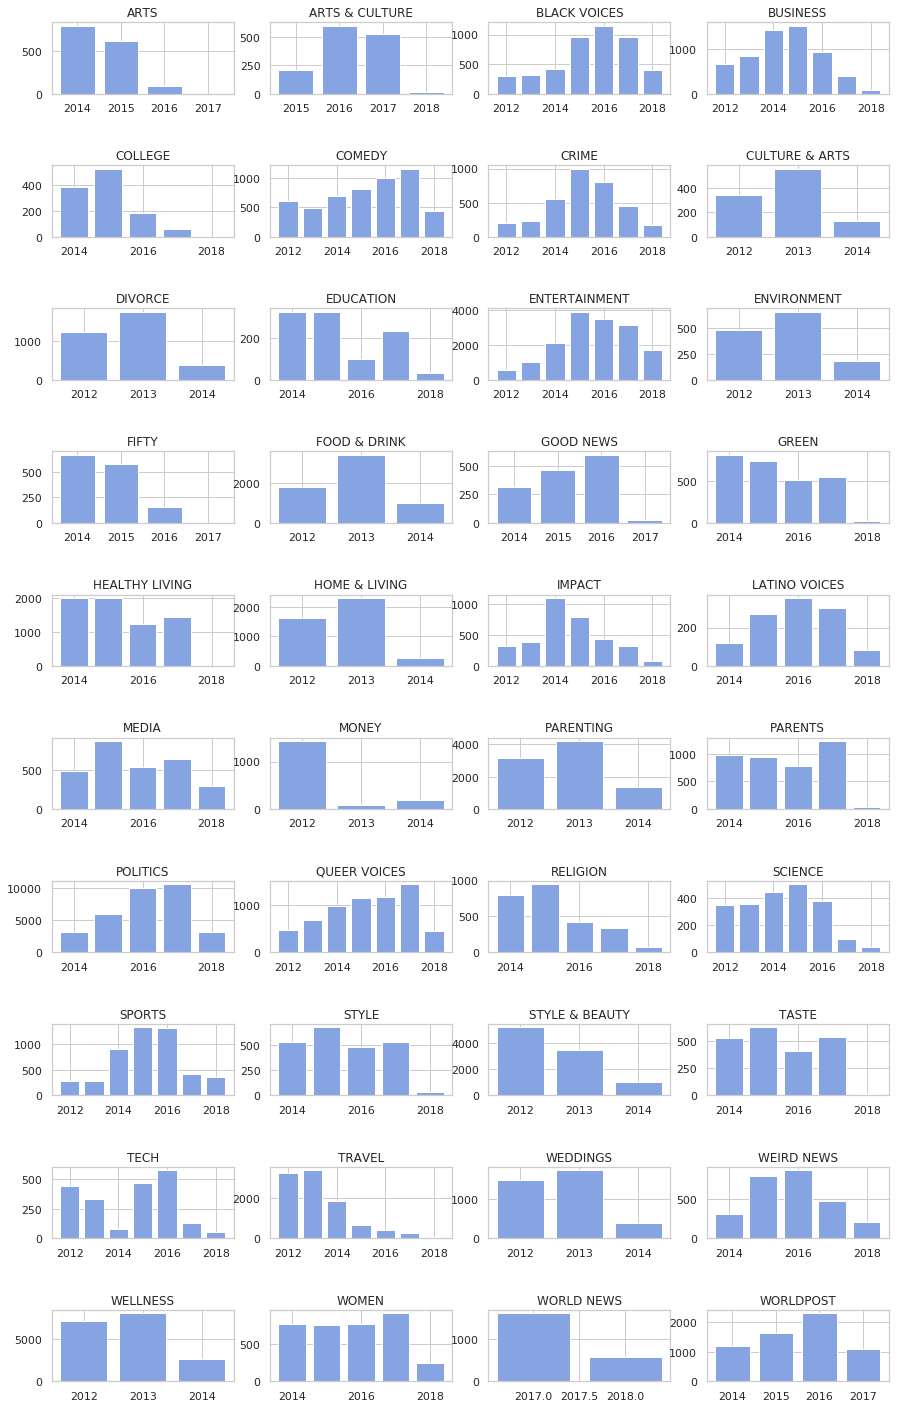

In [0]:

fig1 = plt.figure(figsize=(15,25))
fig1.subplots_adjust(hspace = 1)
chrt = 0
for i, group in df_cat_year.groupby('category'):
    chrt += 1 
    ax = fig1.add_subplot(10,4, chrt)
    x = group['year']
    h = group['qty']
    ax.bar(x,h, color ="#86A3E2")
    ax.set_title(str(i))

**The polarity and subjectivity by category and year**

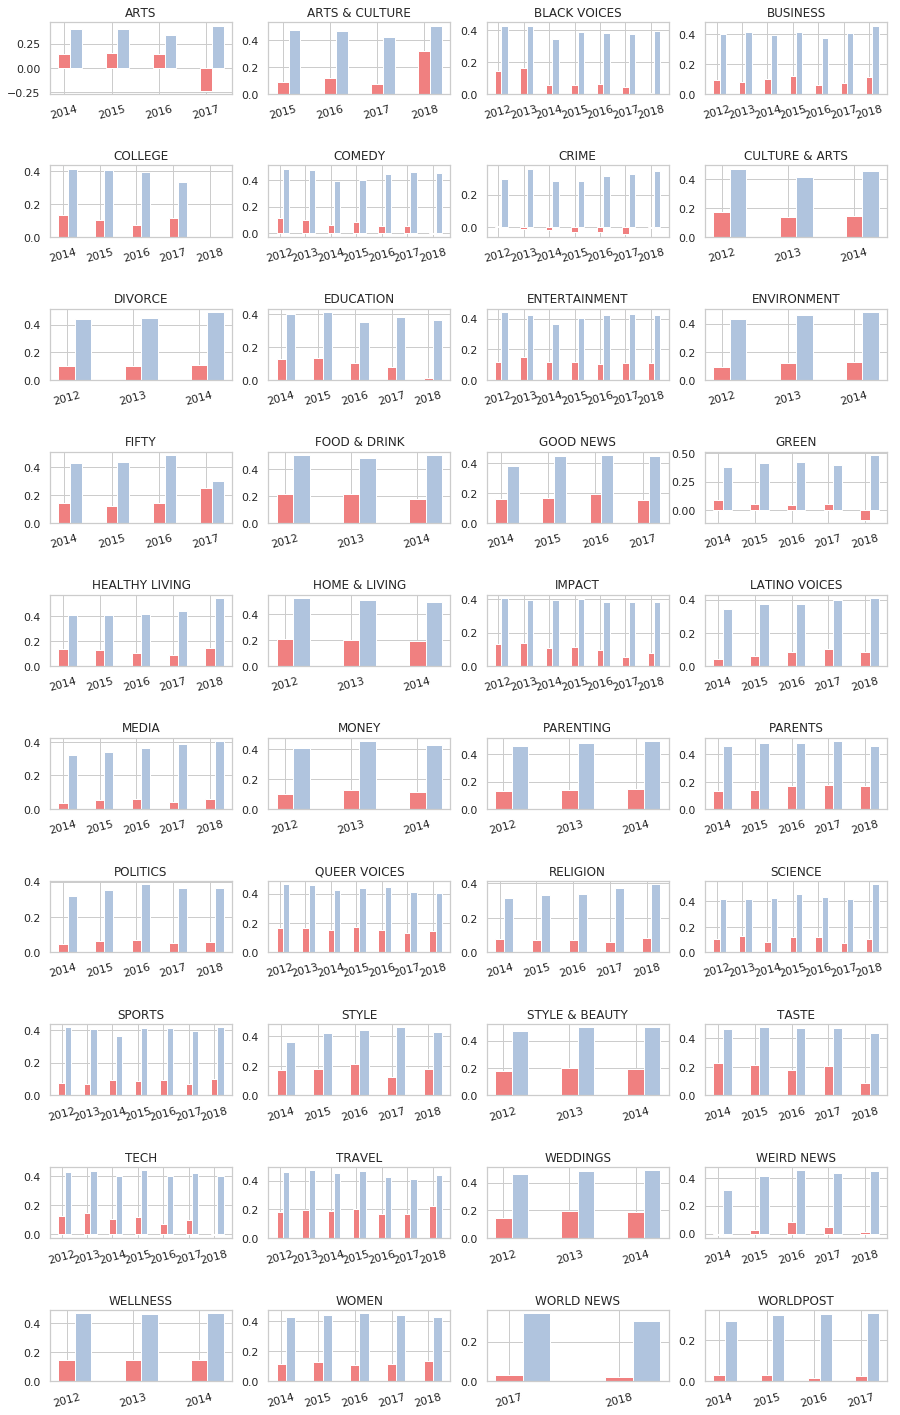

In [0]:
fig1 = plt.figure(figsize=(15,25))
fig1.subplots_adjust(hspace = 1)
chrt = 0
for i, group in df_cat_year.groupby('category'):
    chrt += 1
    barWidth = 0.25
    ax = fig1.add_subplot(10,4, chrt)
    x = group.year
    bars1 = group.polarity
    bars2 = group.subjectivity
    r1 = np.arange(len(x))
    r2 = [x + barWidth for x in r1]

    ax.bar(r1, bars1, color='#F08080', width=barWidth, edgecolor='white', label='Polarity')
    ax.bar(r2, bars2, color='#B0C4DE', width=barWidth, edgecolor='white', label='Subjectivity')
    ax.set_title(str(i))
    ax.set_xticks(range(len(bars1)))
    ax.set_xticklabels([str(x1) for x1 in x], rotation=15)

### The stats by category 

the mean of number of words and unique  by category

In [0]:
df_stats['category'] = df_news['category']
df_stats.head()

,n_chars,n_long_words,n_monosyllable_words,n_polysyllable_words,n_sents,n_syllables,n_unique_words,n_words,category
0,111,5,21,2,6,35,26,27,CRIME
1,80,1,19,1,3,24,20,21,ENTERTAINMENT
2,110,5,17,1,4,35,23,25,ENTERTAINMENT
3,128,6,19,1,2,34,26,26,ENTERTAINMENT
4,128,6,14,4,2,43,24,26,ENTERTAINMENT


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

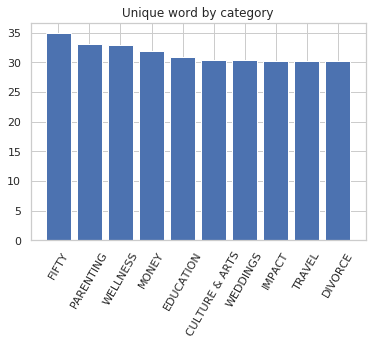

In [0]:

plt.bar(x="category",height ='n_unique_words'  ,data=df_stats.groupby(['category']).mean().sort_values('n_unique_words', ascending=False).head(10).reset_index())
plt.title('Unique word by category')
plt.xticks(rotation=60)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

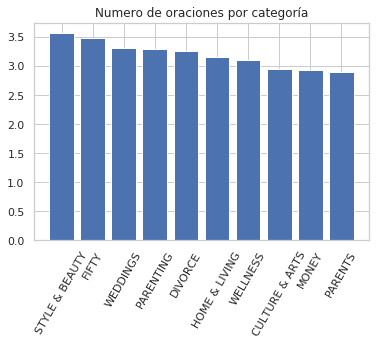

In [0]:
plt.bar(x="category",height ='n_sents'  ,data=df_stats.groupby(['category']).mean().sort_values('n_sents', ascending=False).head(10).reset_index())
plt.title('Numero de oraciones por categoría')
plt.xticks(rotation=60)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

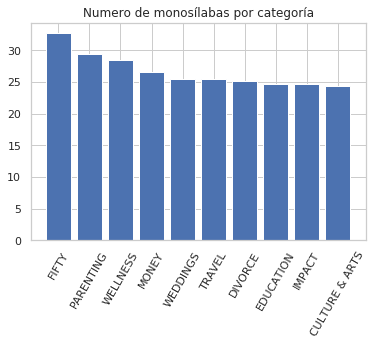

In [0]:
plt.bar(x="category",height ='n_monosyllable_words'  ,data=df_stats.groupby(['category']).mean().sort_values('n_monosyllable_words', ascending=False).head(10).reset_index())
plt.title('Numero de monosílabas por categoría')
plt.xticks(rotation=60)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

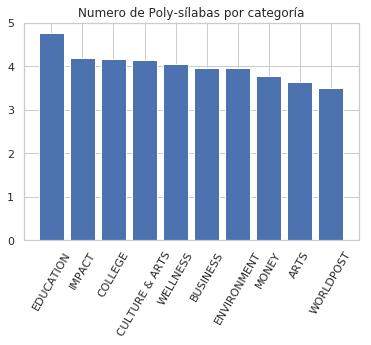

In [0]:
plt.bar(x="category",height ='n_polysyllable_words'  ,data=df_stats.groupby(['category']).mean().sort_values('n_polysyllable_words', ascending=False).head(10).reset_index())
plt.title('Numero de Poly-sílabas por categoría')
plt.xticks(rotation=60)

In [0]:
df_stats.groupby(['category']).mean().sort_values('n_unique_words', ascending=False).head(10).reset_index()

,category,n_chars,n_long_words,n_monosyllable_words,n_polysyllable_words,n_sents,n_syllables,n_unique_words,n_words
0,FIFTY,187.716631,7.615989,32.722341,3.416131,3.487509,58.931478,34.887937,43.596717
1,PARENTING,175.187738,7.382505,29.361991,3.162844,3.303331,54.370981,33.041143,39.809266
2,WELLNESS,182.984350,8.411623,28.528356,4.066416,3.113704,56.871824,32.871487,39.945476
3,MONEY,175.577036,8.207967,26.587581,3.782660,2.926186,54.367311,31.903339,38.104277
4,EDUCATION,181.299801,9.750996,24.740040,4.763944,2.594622,56.725100,30.918327,37.262948
5,CULTURE & ARTS,172.521359,8.645631,24.342718,4.153398,2.958252,53.138835,30.383495,35.931068
6,WEDDINGS,164.567790,7.893728,25.477951,2.758422,3.303752,50.108737,30.365105,36.019721
7,IMPACT,170.427580,8.387684,24.691529,4.195721,2.625903,53.260191,30.229835,36.130963
8,TRAVEL,164.866997,7.431273,25.420856,3.356326,2.793567,50.717204,30.220896,35.910691
9,DIVORCE,162.726795,7.809107,25.209866,2.980736,3.265032,50.410683,30.161705,35.822825


### What can be said about the authors?


In [0]:
df_news['qty']= 1
df_authors = df_news.groupby(['authors']).agg({'polarity': 'mean', 
                                     'subjectivity': 'mean', 
                                    'len': 'mean',
                                     'qty':'count'}).reset_index()
df_authors.head()

,authors,polarity,subjectivity,len,qty
0,,0.112687,0.404000,0.565303,36620
1,"Basil Kreimendahl, Contributor\nPlaywright",0.255556,0.277778,0.421875,1
2,"Bill Bigelow, ContributorRethinking Schools c...",0.000000,0.000000,0.666667,1
3,"Bustle, Contributor\nNews, entertainment, lif...",0.087222,0.519444,0.443750,2
4,"Bustle, ContributorNews, entertainment, lifes...",0.033929,0.555357,0.551724,1


In [0]:
df_authors.drop([0], axis=0, inplace =True)

In [0]:
df_authors.reset_index(drop=True, inplace=True)
df_authors.head()

,authors,polarity,subjectivity,len,qty
0,"Basil Kreimendahl, Contributor\nPlaywright",0.255556,0.277778,0.421875,1
1,"Bill Bigelow, ContributorRethinking Schools c...",0.000000,0.000000,0.666667,1
2,"Bustle, Contributor\nNews, entertainment, lif...",0.087222,0.519444,0.443750,2
3,"Bustle, ContributorNews, entertainment, lifes...",0.033929,0.555357,0.551724,1
4,"Cristian Farias, Elise Foley, and Willa Frej",-0.131818,0.577273,0.769231,1


####  Top Prolifics Authors

In [0]:
df_authors.sort_values(['qty'], ascending=False).head(10)

,authors,polarity,subjectivity,len,qty
16030,Lee Moran,0.060869,0.451287,0.626697,2423
23062,Ron Dicker,0.074317,0.415042,0.626440,1913
22334,"Reuters, Reuters",0.071301,0.385869,0.576494,1562
7958,Ed Mazza,0.033734,0.428158,0.633041,1322
5352,Cole Delbyck,0.096250,0.415951,0.625373,1140
1695,Andy McDonald,0.097788,0.446390,0.578521,1068
13768,Julia Brucculieri,0.161162,0.471812,0.613241,1059
4148,Carly Ledbetter,0.121143,0.431804,0.601758,1054
5633,Curtis M. Wong,0.170989,0.433931,0.628041,1020
18129,Mary Papenfuss,0.007743,0.375507,0.642493,974


In [0]:
def plot_grouped_bar(df, title):
  barWidth = 0.25

  # set height of bar
  bars1 = df.polarity
  bars2 = df.subjectivity

  # Set position of bar on X axis
  r1 = np.arange(len(bars1))
  r2 = [x + barWidth for x in r1]

  # Make the plot
  plt.figure(figsize=(15,10))
  plt.bar(r1, bars1, color='#F08080', width=barWidth, edgecolor='white', label='Polarity')
  plt.bar(r2, bars2, color='#B0C4DE', width=barWidth, edgecolor='white', label='Subjectivity')

  # Add xticks on the middle of the group bars
  plt.title(title)
  plt.xlabel('group', fontweight='bold')
  plt.xticks([r + barWidth for r in range(len(bars1))], df.authors)
  plt.xticks(rotation=60)
  plt.legend()
  plt.show()

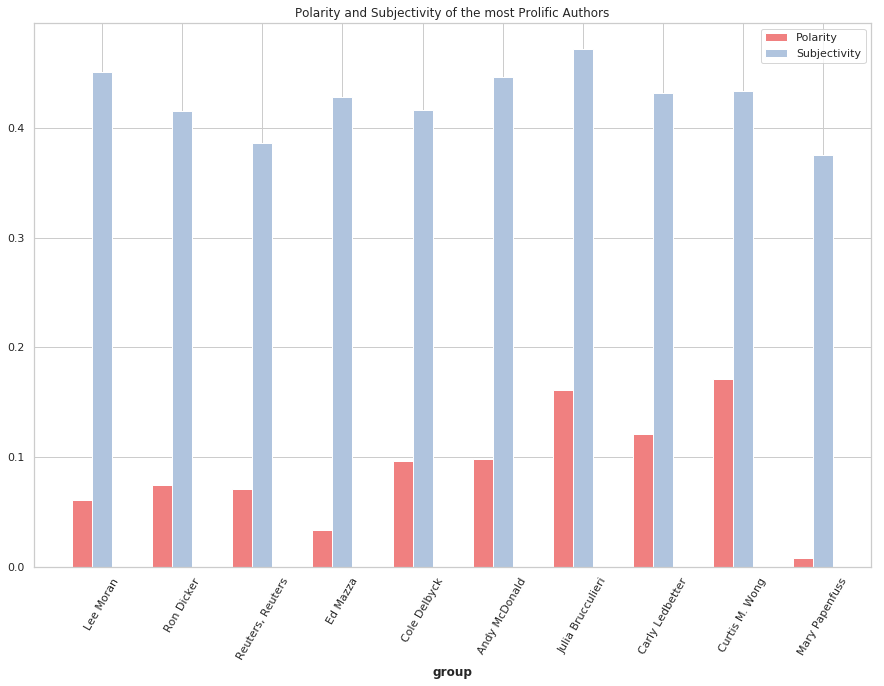

In [0]:
plot_grouped_bar(df_authors.sort_values(['qty'], ascending=False).head(10), "Polarity and Subjectivity of the most Prolific Authors")

By means the author with the most articles  have written around 1000 articles along the years, with a hight subjectivity an neutral polarity.

In [0]:
df_authors[df_authors.qty >100].sort_values(['polarity'], ascending=False).head(10)

,authors,polarity,subjectivity,len,qty
26908,"Travel + Leisure, Contributor\nTravelandLeisur...",0.305529,0.480909,0.546777,122
12172,"Jennifer Segal, ContributorChef, Recipe Develo...",0.303885,0.605824,0.518836,143
20751,"Oyster.com, Contributor\nThe Hotel Tell-All",0.297853,0.529083,0.510710,290
16434,"Liquor.com, Contributor\nLiquor.com",0.282096,0.553024,0.535866,101
26261,"The Daily Meal, Contributor\nAll things food a...",0.280164,0.501047,0.518881,180
13754,Julee Wilson,0.273514,0.470339,0.581722,234
18560,Megan Mayer,0.252103,0.444523,0.535721,116
5416,"Conde Nast Traveler, Contributor\nConde Nast T...",0.247024,0.517208,0.518978,143
18106,"Mary Kincaid, Contributor\nFounder and Editor ...",0.241561,0.429869,0.581201,170
13916,Julie R. Thomson,0.236535,0.465156,0.532825,650


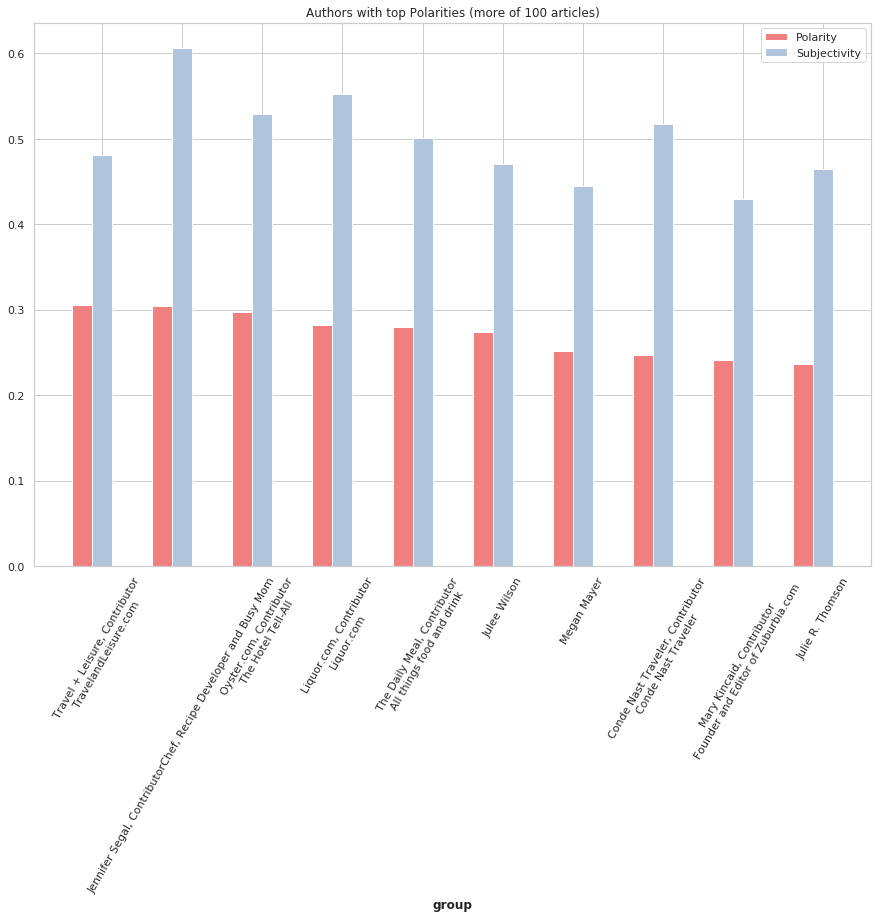

In [0]:

plot_grouped_bar(df_authors[df_authors.qty >100].sort_values(['polarity'], ascending=False).head(10), "Authors with top Polarities (more of 100 articles)")

In [0]:
df_authors[df_authors.qty >100].sort_values(['subjectivity'], ascending=False).head(10)

,authors,polarity,subjectivity,len,qty
12172,"Jennifer Segal, ContributorChef, Recipe Develo...",0.303885,0.605824,0.518836,143
20370,Nicole Guzzardi,0.214694,0.595222,0.506246,141
16434,"Liquor.com, Contributor\nLiquor.com",0.282096,0.553024,0.535866,101
1344,Amy Marturana,0.227930,0.550965,0.587180,204
19311,Michelle Manetti,0.211422,0.545170,0.539724,876
20751,"Oyster.com, Contributor\nThe Hotel Tell-All",0.297853,0.529083,0.510710,290
26434,"Thrillist, Contributor\nEverything worth carin...",0.169222,0.527998,0.508679,142
4251,Caroline Bologna,0.214041,0.523985,0.600839,762
15835,Lauren Leibowitz,0.219764,0.523952,0.572773,187
21880,Rain Embuscado,0.208742,0.521725,0.558959,172


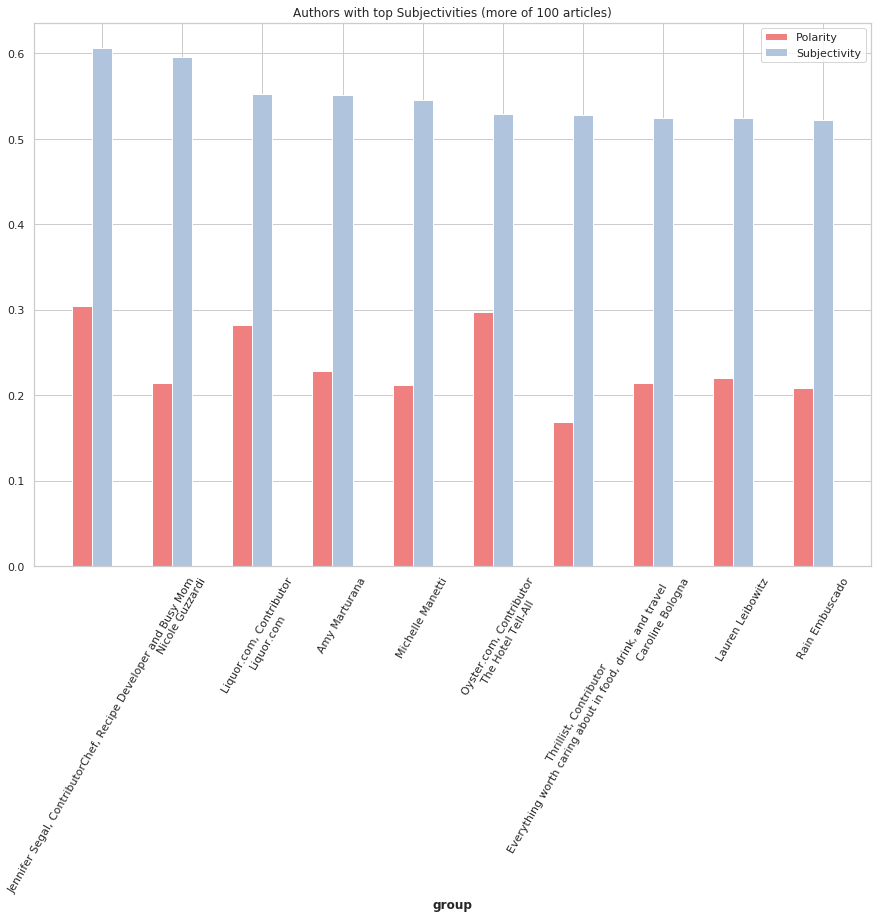

In [0]:
plot_grouped_bar(df_authors[df_authors.qty >100].sort_values(['subjectivity'], ascending=False).head(10), "Authors with top Subjectivities (more of 100 articles)")

### What useful information can be extracted from the data?